In [1]:
from PIL import Image
import os
import glob
from keras.preprocessing import image
import keras.preprocessing
import tensorflow as tf

In [2]:
train_gen = image.ImageDataGenerator(
    rescale = 1/255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_gen = image.ImageDataGenerator(rescale=1/255.0)

In [3]:
train_generator = train_gen.flow_from_directory(
    r"D:\\Github\\Oral-cancer\\Phase 1\\Tongue\\Train\\",
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary')

Found 280 images belonging to 2 classes.


In [4]:
train_generator.class_indices

{'Cancer': 0, 'Non Cancer': 1}

In [5]:
val_generator = test_gen.flow_from_directory(
    r"D:\\Github\\Oral-cancer\\Phase 1\\Tongue\\Val\\",
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary')

Found 94 images belonging to 2 classes.


In [6]:
# Create the VGG16 models

from keras.applications.vgg16 import VGG16
import keras
from keras.layers import *
from keras.models import Model 
import matplotlib.pyplot as plt

In [7]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in model.layers:
    layer.trainable=False

In [8]:
av1 = Flatten()(model.output)
fc1 = Dense(64,activation='relu')(av1)
d1 = Dropout(0.6)(fc1)
fc2 = Dense(1,activation='softmax')(d1)
model_new = Model(model.input,fc2)
model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model_new.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [10]:
hist = model_new.fit(
    train_generator,
    steps_per_epoch = 4,
    epochs = 10,
    batch_size=8,
    validation_data = val_generator,
)

Epoch 1/10
4/4 [==============================] - 12s 2s/step - loss: 0.9678 - accuracy: 0.6406 - val_loss: 1.0941 - val_accuracy: 0.6702
Epoch 2/10
4/4 [==============================] - 1s 381ms/step - loss: 0.8303 - accuracy: 0.7344 - val_loss: 0.7476 - val_accuracy: 0.6702
Epoch 3/10
4/4 [==============================] - 1s 377ms/step - loss: 0.5573 - accuracy: 0.5781 - val_loss: 0.3088 - val_accuracy: 0.6702
Epoch 4/10
4/4 [==============================] - 1s 369ms/step - loss: 0.3910 - accuracy: 0.7188 - val_loss: 0.5636 - val_accuracy: 0.6702
Epoch 5/10
4/4 [==============================] - 1s 364ms/step - loss: 0.4646 - accuracy: 0.6875 - val_loss: 0.2880 - val_accuracy: 0.6702
Epoch 6/10
4/4 [==============================] - 3s 1s/step - loss: 0.3578 - accuracy: 0.7500 - val_loss: 0.3969 - val_accuracy: 0.6702
Epoch 7/10
4/4 [==============================] - 1s 385ms/step - loss: 0.4240 - accuracy: 0.7321 - val_loss: 0.3385 - val_accuracy: 0.6702
Epoch 8/10
4/4 [=========

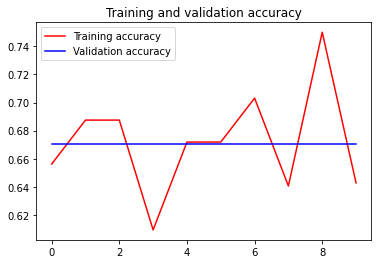

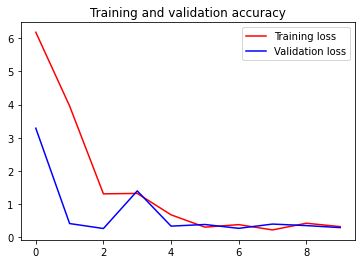

In [19]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(loc=0)
plt.title('Training and validation accuracy')

plt.show()

In [20]:
# Model Interpretability
outputs = [layer.output for layer in model.layers[1:22]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers that will be used for visualization: ")
print(layer_names)

Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


In [24]:
test_batches=16
def get_CAM(processed_image, actual_label, layer_name='block5_conv3'):
    model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        tape.watch(conv_output_values)
        pred_prob = predictions[:,1] 
        actual_label = tf.cast(actual_label, dtype=tf.float32)
        smoothing = 0.00001 
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")
    
    # get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
    # weight the convolution outputs with the computed gradients
    for i in range(512): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [25]:
def show_sample(idx=None):
    
    # if image index is specified, get that image
    if idx:
        for img, label in test_batches.take(idx):
            sample_image = img[0]
            sample_label = label[0]
    # otherwise if idx is not specified, get a random image
    else:
        for img, label in test_batches.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]
    
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    
    activations = vis_model.predict(sample_image_processed)
    
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    sample_activation = activations[0][0,:,:,16]
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

In [26]:
# Choose an image index to show, or leave it as None to get a random image
activations = show_sample(idx=None)

AttributeError: 'int' object has no attribute 'shuffle'

# VGG 19

In [12]:
from keras.applications.vgg19 import VGG19

In [13]:
model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in model.layers:
    layer.trainable=False

In [14]:
av1 = Flatten()(model.output)
fc1 = Dense(64,activation='relu')(av1)
d1 = Dropout(0.6)(fc1)
fc2 = Dense(1,activation='softmax')(d1)
model_new = Model(model.input,fc2)
model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [15]:
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model_new.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [16]:
hist = model_new.fit(
    train_generator,
    steps_per_epoch = 4,
    epochs = 10,
    batch_size=16,
    validation_data = val_generator,
)

Epoch 1/10
4/4 [==============================] - 2s 445ms/step - loss: 6.1843 - accuracy: 0.6562 - val_loss: 3.2859 - val_accuracy: 0.6702
Epoch 2/10
4/4 [==============================] - 2s 419ms/step - loss: 3.9563 - accuracy: 0.6875 - val_loss: 0.4056 - val_accuracy: 0.6702
Epoch 3/10
4/4 [==============================] - 1s 390ms/step - loss: 1.3027 - accuracy: 0.6875 - val_loss: 0.2556 - val_accuracy: 0.6702
Epoch 4/10
4/4 [==============================] - 1s 387ms/step - loss: 1.3162 - accuracy: 0.6094 - val_loss: 1.3920 - val_accuracy: 0.6702
Epoch 5/10
4/4 [==============================] - 1s 398ms/step - loss: 0.6696 - accuracy: 0.6719 - val_loss: 0.3278 - val_accuracy: 0.6702
Epoch 6/10
4/4 [==============================] - 1s 394ms/step - loss: 0.2969 - accuracy: 0.6719 - val_loss: 0.3773 - val_accuracy: 0.6702
Epoch 7/10
4/4 [==============================] - 1s 379ms/step - loss: 0.3732 - accuracy: 0.7031 - val_loss: 0.2610 - val_accuracy: 0.6702
Epoch 8/10
4/4 [====